In [32]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, LSTM, TextVectorization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import keras


In [33]:
df = pd.read_csv('Reviews.csv')

In [34]:
user_enc = LabelEncoder()
item_enc = LabelEncoder()

df['user'] = user_enc.fit_transform(df['UserId'].astype(str))
df['item'] = item_enc.fit_transform(df['ProductId'].astype(str))

num_users = df['user'].nunique()
num_items = df['item'].nunique()


In [35]:
X = df[['user', 'item', 'Text']]
y = df['Score'].astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
train_user_input = tf.convert_to_tensor(X_train['user'].values, dtype=tf.int32)
train_item_input = tf.convert_to_tensor(X_train['item'].values, dtype=tf.int32)
train_text_input = tf.convert_to_tensor(X_train['Text'].astype(str).tolist(), dtype=tf.string)

val_user = tf.convert_to_tensor(X_test['user'].values, dtype=tf.int32)
val_item = tf.convert_to_tensor(X_test['item'].values, dtype=tf.int32)
val_text = tf.convert_to_tensor(X_test['Text'].astype(str).tolist(), dtype=tf.string)

y_train_tensor = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test.values, dtype=tf.float32)

print(train_user_input.dtype, train_user_input.shape)   # tf.int32
print(train_item_input.dtype, train_item_input.shape)   # tf.int32
print(train_text_input.dtype, train_text_input.shape)   # tf.string

print(val_user.dtype, val_user.shape)   # tf.int32
print(val_item.dtype, val_item.shape)   # tf.int32
print(val_text.dtype, val_text.shape)   # tf.string

print(y_train_tensor.dtype, y_train_tensor.shape)   # tf.float32
print(y_test_tensor.dtype, y_test_tensor.shape)   # tf.float32

<dtype: 'int32'> (454763,)
<dtype: 'int32'> (454763,)
<dtype: 'string'> (454763,)
<dtype: 'int32'> (113691,)
<dtype: 'int32'> (113691,)
<dtype: 'string'> (113691,)
<dtype: 'float32'> (454763,)
<dtype: 'float32'> (113691,)


In [39]:
text_vec = TextVectorization(output_sequence_length=100, max_tokens=5000)
text_ds = tf.data.Dataset.from_tensor_slices(train_text_input).batch(32)
text_vec.adapt(text_ds)

In [40]:
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')
text_input = Input(shape=(1,), dtype=tf.string, name='text_input')


In [41]:
user_embedding = Embedding(input_dim=num_users, output_dim=32, name='user_embedding')(user_input)
item_embedding = Embedding(input_dim=num_items, output_dim=32, name='item_embedding')(item_input)

user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)

In [42]:

# Text Embedding via LSTM
x = text_vec(text_input)
x = Embedding(input_dim=5000, output_dim=32)(x)
x = LSTM(64)(x)
review_vec = x

In [43]:
combined = Concatenate()([user_vec, item_vec, review_vec])
x = Dense(128, activation='relu')(combined)
x = Dense(64, activation='relu')(x)
output = Dense(1)(x)

model = Model(inputs=[user_input, item_input, text_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [44]:
X_train['Text'].astype(str).values

array(["Like many others have said, this is INSTANT coffee, not only that but it is terrible instant coffee. Don't Buy!",
       "We are a 2 person household with one diabetic and one low-carber.  We love this pasta and eat it at least once per week.  We haven't noticed any appreciable rise in blood glucose level, or any negative effects on low-carb dieting while using this product.  Of course we limit the portion and eat it with plenty of protein and vegetables, which probably helps prevent glucose/insulin spikes.  I think we have had success because the proportion of pasta to protein and vegetables is low.  But essentially this pasta is delicious and we highly recommend it.",
       'These might be the best chips I have ever had.  The "Used By" date is March 2011, but I had to cut this bag open as it was sealed up so tightly (this is the first bag of chips I\'ve had to cut open..if I really reeked on it I could have got it, but I didn\'t want it to explode in my face).  No worries, y

In [46]:
print(train_user_input.dtype, train_user_input.shape)   # tf.int32
print(train_item_input.dtype, train_item_input.shape)   # tf.int32
print(train_text_input.dtype, train_text_input.shape)   # tf.string

print(val_user.dtype, val_user.shape)   # tf.int32
print(val_item.dtype, val_item.shape)   # tf.int32
print(val_text.dtype, val_text.shape)   # tf.string

print(y_train_tensor.dtype, y_train_tensor.shape)   # tf.float32
print(y_test_tensor.dtype, y_test_tensor.shape)   # tf.float32

<dtype: 'int32'> (454763,)
<dtype: 'int32'> (454763,)
<dtype: 'string'> (454763,)
<dtype: 'int32'> (113691,)
<dtype: 'int32'> (113691,)
<dtype: 'string'> (113691,)
<dtype: 'float32'> (454763,)
<dtype: 'float32'> (113691,)


In [48]:
history = model.fit(
    [train_user_input, train_item_input, train_text_input],
    y_train_tensor,
    validation_data=([val_user, val_item, val_text], y_test_tensor),
    epochs=10,
    batch_size=256,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)


Epoch 1/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 246s 138ms/step - loss: 2.0124 - mae: 1.0318 - val_loss: 0.5750 - val_mae: 0.4845
Epoch 2/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 267s 150ms/step - loss: 0.3342 - mae: 0.3499 - val_loss: 0.5170 - val_mae: 0.4306
Epoch 3/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 225s 126ms/step - loss: 0.1728 - mae: 0.2374 - val_loss: 0.5329 - val_mae: 0.4555
Epoch 4/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 236s 133ms/step - loss: 0.1173 - mae: 0.1892 - val_loss: 0.5060 - val_mae: 0.4068
Epoch 5/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 255s 143ms/step - loss: 0.0863 - mae: 0.1570 - val_loss: 0.5171 - val_mae: 0.4128
Epoch 6/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 253s 142ms/step - loss: 0.0650 - mae: 0.1339 - val_loss: 0.5072 - val_mae: 0.3926


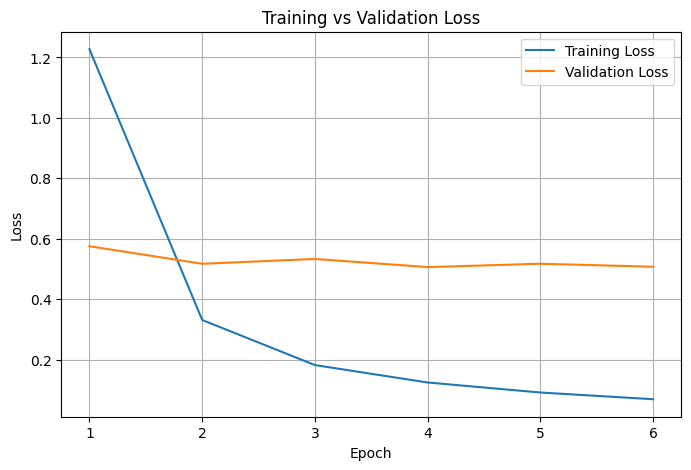

In [50]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama loss değerlerini al
loss = history.history['loss']
val_loss = history.history['val_loss']

# Epoch sayısına göre x ekseni
epochs = range(1, len(loss) + 1)

# Grafik çizimi
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
# Encode edilmiş user ve item ID'leri
sample_user = tf.constant([val_user[0].numpy()], dtype=tf.int32)
sample_item = tf.constant([val_item[0].numpy()], dtype=tf.int32)
sample_text = tf.constant(["this is a test review"], dtype=tf.string)

# Şimdi predict
pred = model.predict([sample_user, sample_item, sample_text])
print(f"Tahmin edilen puan: {pred[0][0]:.2f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tahmin edilen puan: 3.46


In [52]:
def recommend_for_user(raw_user_id, top_n=5):
    # Kullanıcıyı encode et
    encoded_user = user_enc.transform([raw_user_id])[0]

    # Bu kullanıcı daha önce hangi ürünleri puanlamış
    seen_items = df[df['user'] == encoded_user]['item'].values

    # Tüm ürünlerden daha önce görmediklerini bul
    candidate_items = [i for i in range(num_items) if i not in seen_items]

    if not candidate_items:
        print("Bu kullanıcı tüm ürünleri görmüş gibi 🤷")
        return []

    # Dummy review (şu anda gerçek yorum bilmediğimiz için)
    dummy_reviews = tf.constant(["this is a placeholder review"] * len(candidate_items), dtype=tf.string)

    # Modelin istediği şekle sok
    user_tensor = tf.constant([encoded_user] * len(candidate_items), dtype=tf.int32)
    item_tensor = tf.constant(candidate_items, dtype=tf.int32)

    # Tahminleri al
    preds = model.predict([user_tensor, item_tensor, dummy_reviews], verbose=0)

    # En yüksek puanlı ürünleri sırala
    top_indices = preds.flatten().argsort()[-top_n:][::-1]
    top_item_ids = [candidate_items[i] for i in top_indices]

    # Orijinal ProductId'lere çevir
    return item_enc.inverse_transform(top_item_ids)


In [53]:
model = keras.models.load_model('recommender_model.keras')

In [54]:
user_id = "A10ZK1IH0PDGJU"  # Örnek kullanıcı ID'si (raw ID)
recommended_products = recommend_for_user(user_id, top_n=5)
print("Önerilen Ürünler:", recommended_products)


Önerilen Ürünler: ['B001BCUB7S' 'B007NRQ4O4' 'B001IZK5V0' 'B004NC82MY' 'B00061MUNS']


In [55]:
def get_user_reviewed_products(user_id, reviews_df):
    user_reviews = reviews_df[reviews_df["UserId"] == user_id]
    if user_reviews.empty:
        print(f"❌ Kullanıcı {user_id} için yorum bulunamadı.")
        return

    print(f"👤 Kullanıcı: {user_id}")
    print(f"🧾 Yorum sayısı: {len(user_reviews)}\n")

    for idx, row in user_reviews.iterrows():
        print(f"📦 Ürün ID: {row['ProductId']}")
        print(f"💬 Yorum: {row['Text']}")
        print("-" * 50)


In [56]:
def get_reviews_for_products(product_ids, reviews_df):
    if isinstance(product_ids, str):
        product_ids = [product_ids]

    matched_reviews = reviews_df[reviews_df["ProductId"].isin(product_ids)]

    if matched_reviews.empty:
        print("❌ Bu ürün(ler) için yorum bulunamadı.")
        return

    for idx, row in matched_reviews.iterrows():
        print(f"📦 Ürün ID: {row['ProductId']}")
        print(f"👤 Kullanıcı: {row['UserId']}")
        print(f"💬 Yorum: {row['Text']}")
        print("-" * 50)


In [57]:
get_reviews_for_products(["B001BCUB7S"], df)

📦 Ürün ID: B001BCUB7S
👤 Kullanıcı: A2SZLNSI5KOQJT
💬 Yorum: All of my cats will try to eat this food.  However, the chicken chunks are on the largish side, so my older cats don't finish their portion(s) and will end up licking the "juice" off of the chunks.  My youngest cat (under 1 year old) will eat all of the food - chunks, juice and all.
--------------------------------------------------
📦 Ürün ID: B001BCUB7S
👤 Kullanıcı: A87JI1JMRS0PG
💬 Yorum: A great food for a decent price.  My kitty is crazy about the chunks, I think they are a good diversion from the usual pât&eacute; style canned cat food.  Yes, it has vegetables in it, but not an overbearing amount.  I recommend it.
--------------------------------------------------
📦 Ürün ID: B001BCUB7S
👤 Kullanıcı: A1FNQRQHWS8949
💬 Yorum: This stuff is a little spendy for my budget, but it's worth it. We're on our third case, and my two cats clean their bowls. Partly because maybe they're still a little hungry -- splitting a 3 oz. can betwe

In [58]:
get_user_reviewed_products("A10ZK1IH0PDGJU", df)

👤 Kullanıcı: A10ZK1IH0PDGJU
🧾 Yorum sayısı: 13

📦 Ürün ID: B000NVDZ0I
💬 Yorum: These peppers have good color, aroma, and taste. I ordered a pound and am quite pleased with the amount of product per dollar. We use green peppers for many things: poaching salmon, flavoring corned beef, ground in salads, etc. So far I've found the peppers competitive with any other green peppers I've bought and they are less expensive to boot.
--------------------------------------------------
📦 Ürün ID: B000E1694G
💬 Yorum: Just the right size for lunch on a cold day.  Easy to make.  Great taste.
--------------------------------------------------
📦 Ürün ID: B000NVCK68
💬 Yorum: These peppers have good color, aroma, and taste. I ordered a pound and am quite pleased with the amount of product per dollar. We use green peppers for many things: poaching salmon, flavoring corned beef, ground in salads, etc. So far I've found the peppers competitive with any other green peppers I've bought and they are less expens

In [58]:
model.save('recommender_model.keras')

In [60]:
import keras
model2 = keras.saving.load_model('recommender_model.keras')